In [0]:
# Load the google drive
from google.colab import drive
drive.mount('/content/gdrive')
directory = '/content/gdrive/My Drive/Flickr8k'
image_directory = directory + '/Flickr8k_Dataset/Flicker8k_Dataset'
token_directory = directory + '/Flickr8k_text'
daniels_directory = directory + '/daniels'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Skip this if once done
# Image encoder model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
model = InceptionV3(weights = 'imagenet', include_top=False, pooling='avg')
print('Model input shape : {}'.format(model.layers[0].input_shape))
print('Model output shape : {}'.format(model.layers[-1].output_shape))

In [0]:
# Skip this if once done
# Encode all the images and store in a dictionary
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

features = dict()
for name in tqdm(listdir(image_directory)):
  filename = image_directory + '/' + name
  if not filename.endswith('.jpg'):
    continue
  image = load_img(filename, target_size=(299, 299))
  image = img_to_array(image)
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  image = preprocess_input(image)
  feature = model.predict(image)
  features[name.split('.')[0]] = feature
print('Total images and features : {}'.format(len(features)))

In [0]:
# Skip this if once done
# Save the features just learned
from pickle import dump
dump(features, open(daniels_directory + '/image_features.p', 'wb'))

In [0]:
# Skip if once done
# Create a dictionary of image ids and caption lists
image_caption_dict = dict()
with open(token_directory + '/Flickr8k.token.txt', 'r') as file:
  lines = file.read().strip().split('\n')
  for line in lines:
    image_id, caption = line.split('\t')
    image_id = image_id[:-6]
    if image_id not in image_caption_dict.keys():
      image_caption_dict[image_id] = list()
    image_caption_dict[image_id].append('<start> ' + caption + ' <end>')  # Putting EOF marker if necessary

# Create a list of training set image ids
train_image_list = list()
with open(token_directory + '/Flickr_8k.trainImages.txt', 'r') as file:
  lines = file.read().strip().split('\n')
  for line in lines:
    train_image_list.append(line[:-4])
    
# Create a list of validation set image ids
val_image_list = list()
with open(token_directory + '/Flickr_8k.devImages.txt', 'r') as file:
  lines = file.read().strip().split('\n')
  for line in lines:
    val_image_list.append(line[:-4])

# Create a list of testing set image ids
test_image_list = list()
with open(token_directory + '/Flickr_8k.testImages.txt', 'r') as file:
  lines = file.read().strip().split('\n')
  for line in lines:
    test_image_list.append(line[:-4])

# Display information
print('Length of training set : ', len(train_image_list))
print('Length of validation set : ', len(val_image_list))
print('Length of testing set : ', len(test_image_list))

Length of training set :  6000
Length of validation set :  1000
Length of testing set :  1000


In [0]:
# Skip if once done
# Divide the caption dictionary according to image id lists and save in a pickle file
from pickle import dump
filterByKey = lambda keys: {x: image_caption_dict[x] for x in keys}

train_caption_dict = filterByKey(train_image_list)
val_caption_dict = filterByKey(val_image_list)
test_caption_dict = filterByKey(test_image_list)

dump(train_caption_dict, open(daniels_directory + '/train_caption_dict.p', 'wb'))
dump(val_caption_dict, open(daniels_directory + '/val_caption_dict.p', 'wb'))
dump(test_caption_dict, open(daniels_directory + '/test_caption_dict.p', 'wb'))

In [0]:
# Load all preprocessed data from pickle file
from pickle import load

image_features = load(open(daniels_directory + '/image_features.p', 'rb'))
train_caption_dict = load(open(daniels_directory + '/train_caption_dict.p', 'rb'))
val_caption_dict = load(open(daniels_directory + '/val_caption_dict.p', 'rb'))
test_caption_dict = load(open(daniels_directory + '/test_caption_dict.p', 'rb'))

print(test_caption_dict)

{'3385593926_d3e9c21170': ['<start> The dogs are in the snow in front of a fence . <end>', '<start> The dogs play on the snow . <end>', '<start> Two brown dogs playfully fight in the snow . <end>', '<start> Two brown dogs wrestle in the snow . <end>', '<start> Two dogs playing in the snow . <end>'], '2677656448_6b7e7702af': ['<start> a brown and white dog swimming towards some in the pool <end>', '<start> A dog in a swimming pool swims toward sombody we cannot see . <end>', '<start> A dog swims in a pool near a person . <end>', '<start> Small dog is paddling through the water in a pool . <end>', '<start> The small brown and white dog is in the pool . <end>'], '311146855_0b65fdb169': ['<start> A man and a woman in festive costumes dancing . <end>', '<start> A man and a woman with feathers on her head dance . <end>', '<start> A man and a woman wearing decorative costumes and dancing in a crowd of onlookers . <end>', '<start> one performer wearing a feathered headdress dancing with anothe

In [0]:
# Skip if once done
# Creating a tokenizer and fitting on the train captions and saving the tokenizer
from pickle import dump
all_train_captions = list(train_caption_dict.values())
all_train_captions = [caption for sublist in all_train_captions for caption in sublist]

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~')  # All default filters except < and >
tokenizer.fit_on_texts(all_train_captions)

# Add a <unf> for 0 index
tokenizer.word_index['<unf>'] = 0
dump(tokenizer, open(daniels_directory + '/tokenizer.p', 'wb'))

Using TensorFlow backend.


In [0]:
# Load the tokenizer and find vocabulary length
from pickle import load
tokenizer = load(open(daniels_directory + '/tokenizer.p', 'rb'))
vocab_size = len(tokenizer.word_index)
print('Vocabulary size : ', vocab_size)

# Maximum length of any caption in training data
max_len = max([len(caption.split()) for sublist in list(train_caption_dict.values()) for caption in sublist])
print('Maximum length of any caption : ', max_len)

Vocabulary size :  7378
Maximum length of any caption :  40


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_5_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_13_input (InputLayer)     (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 300)      2213400     embedding_5_input[0][0]          
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 300)          614700      dense_13_input[0][0]             
__________________________________________________________________________________________________
lstm_9 (LS

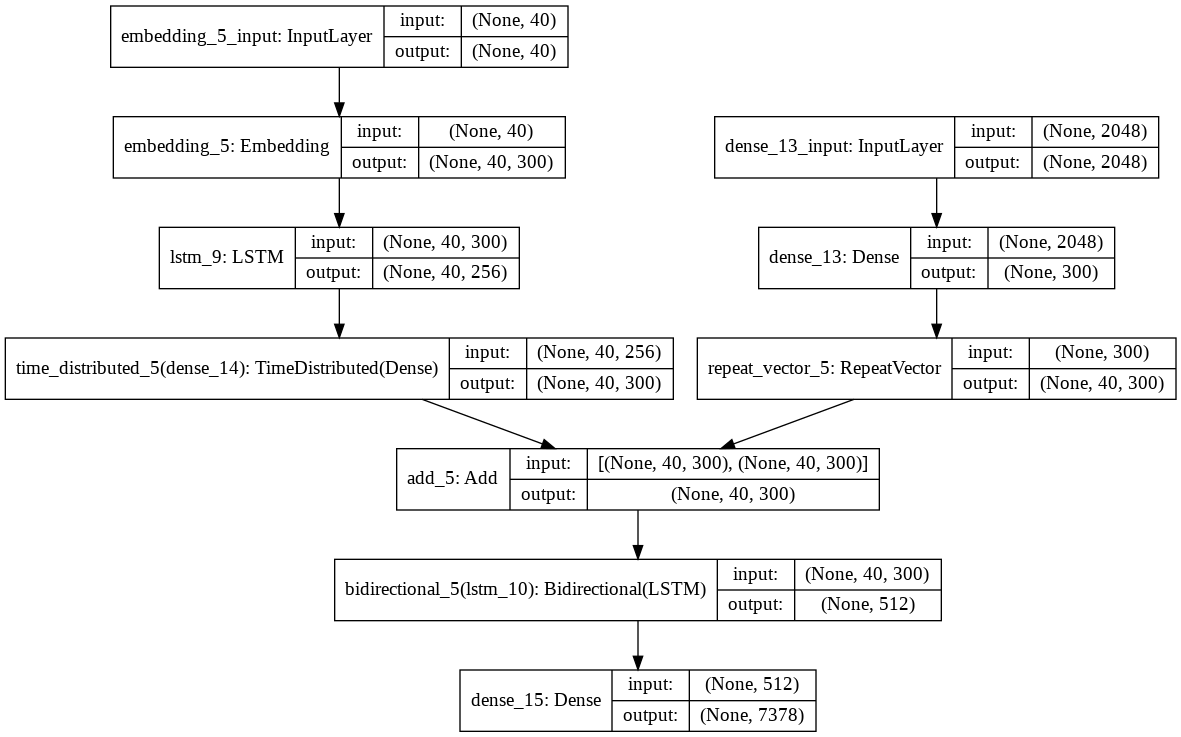

In [0]:
# Skip if once done
# Initialize the embedding size
embedding_size = 300

# Create the image input model
from keras.models import Sequential
from keras.layers import Dense, RepeatVector
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

# Create the caption input model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, TimeDistributed
caption_model = Sequential()
caption_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
caption_model.add(LSTM(256, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))
caption_model.add(TimeDistributed(Dense(embedding_size)))

# Prepare the sequence model
from keras.layers import Concatenate, Add, LSTM, Bidirectional, TimeDistributed, Dense
sequence_layer = Add()([image_model.output, caption_model.output])
sequence_layer = Bidirectional(LSTM(units=256, return_sequences=False, dropout=0.25, recurrent_dropout=0.25))(sequence_layer)
sequence_output = Dense(units=vocab_size, activation='softmax')(sequence_layer)

from keras.models import Model
model = Model(inputs=[image_model.input, caption_model.input], outputs=sequence_output)
print(model.summary())

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
from pickle import dump
dump(model, open(daniels_directory + '/model.p', 'wb'))

# Visualize model
from keras.utils import plot_model
from PIL import Image
plot_model(model, to_file=daniels_directory + '/model.png', show_shapes=True)
Image.open(daniels_directory + '/model.png')

In [0]:
# Few helper methods for data generator
def caption_input_process(caption):
  from keras.preprocessing.sequence import pad_sequences
  caption = tokenizer.texts_to_sequences([caption])
  caption = pad_sequences(caption, maxlen=max_len, padding='post')[0]
  return caption

def target_word_process(word):
  word_index = tokenizer.texts_to_sequences([word])[0]
  import numpy as np
  vector = np.zeros(vocab_size)
  vector[word_index] = 1
  return vector

def caption_splitter(caption):
  caption = caption.split()
  cap = ''
  result = [cap]
  for c in caption:
    cap = cap + ' ' + c
    cap = cap.strip()
    result.append(cap)
  return result[1:]

print(caption_splitter('<start> It is a dog <end>'))

['<start>', '<start> It', '<start> It is', '<start> It is a', '<start> It is a dog', '<start> It is a dog <end>']


In [0]:
# Create a data generator for batch-wise training
from keras.utils import to_categorical

def data_generator(batch_size=128):
  import numpy as np
  
  image_input = list()
  caption_input = list()
  target_caption = list()
  
  for image_id, caption_list in train_caption_dict.items():
    for caption in caption_list:
      caption = caption_splitter(caption)
      for i in range(len(caption)-1):
        image_input.append(image_features[image_id].flatten())
        caption_input.append(caption_input_process(caption[i]))
        target_caption.append(target_word_process(caption[i+1].split()[-1]))
        
        if len(image_input) >= batch_size:
          image_input = np.asarray(image_input)
          caption_input = np.asarray(caption_input)
          target_caption = np.asarray(target_caption)
          yield [[image_input, caption_input], target_caption]
          image_input = list()
          caption_input = list()
          target_caption = list()

In [0]:
# Calculating number of epochs for training
batch_size=128
epochs = 0
for cap_list in train_caption_dict.values():
  for caption in cap_list:
    epochs += len(caption.split())

epochs = int(epochs/batch_size)
print(epochs)

3230


In [0]:
# Load model
from pickle import load
model = load(open(daniels_directory + '/model.p', 'rb'))
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.load_weights(daniels_directory + '/weights.h5')

In [0]:
# Fit the model and save weights after each epoch
number_of_epochs = 1
for epoch in range(number_of_epochs):
  print('Current epoch : ', epoch)
  model.fit_generator(data_generator(batch_size), nb_epoch=1, verbose=1, steps_per_epoch=epochs)
  model.save_weights(daniels_directory + '/weights.h5')
  print('Weights saved!')